# Clustering Algorithms on Amazon Fine Food Reviews 

## [ CONTENTS ] 

1. About the dataset<br>
2. Objective<br>
3. Loading the data<br>
4. Data Preprocessing <br>
5. Function Definitions<br>
6. Bag of Words (BoW)<br>
7. TF-IDF<br>
8. Word2Vec<br>
9. Avg W2V & TFIDF-W2V<br>
    9.1 TF-IDF weighted W2V
10. Summary<br>

## 1. About the dataset
1. Title: Amazon Fine Food Reviews. Link:https://www.kaggle.com/snap/amazon-fine-food-reviews
2. Relevant Information: This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.
3. Data includes:
    * Number of reviews: 568,454<br>
    * Number of users: 256,059<br>
    * Number of products: 74,258<br>
    * Timespan: Oct 1999 - Oct 2012<br>
    * Number of Attributes/Columns in data: 10 
4. Attribute Information: 
    * Id
    * ProductId - unique identifier for the product
    * UserId - unqiue identifier for the user
    * ProfileName
    * HelpfulnessNumerator - number of users who found the review helpful
    * HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
    * Score - rating between 1 and 5
    * Time - timestamp for the review
    * Summary - brief summary of the review
    * Text - text of the review

## 2. Objective:
For given Amazon reviews, cluster them into groups using unsupervised algorithms.<br>
<br>
Here I'm using various clustering algorithms(K-means, K-medoid, Hirarchical, DBSCAN) to cluster the reviews into different groups. To convert a review text to numerical features I'm using bag of words(BoW), TF-IDF, Word2Vec and TF-IDF weighted Word2Vec. 

In [1]:
# importing required libraries
import numpy as np
import pandas as pd 
import matplotlib 
import sqlite3
import string
import nltk
import time
from matplotlib import pyplot as plt 
import seaborn as sns 
from scipy import stats
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale, minmax_scale

#Standardizing the data
def standardizer(data):
    stnd_scaler = StandardScaler(with_mean=False)
    stnd_matx = stnd_scaler.fit_transform(data)
    return stnd_matx

## 3. Loading the data

In [3]:
# Loading the previously cleaned data
connect = sqlite3.connect('final_data.sqlite')

#Ignoring the rows which have rating 3
data = pd.read_sql_query("""
SELECT *
FROM Reviews
""", connect)

In [4]:
data.shape

(364171, 12)

In [5]:
data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


## 4. Data Preprocessing

In [6]:
sorted_data = data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [7]:
sorted_data.head(5)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...


## 5. Function Definitions

### 5.1. K-Means Clustering

In [267]:
def kmean_cluster(data, vectorizer, name):
    
    fit_models = []
    num_clusters = np.arange(10, 51, 5)
    if name in ['BoW','TFIDF']:
                
        vect = standardizer(vectorizer.fit_transform(data['CleanedText'].values))
        for i in num_clusters:
            clf = KMeans(n_clusters = i, n_init = 8, n_jobs = -1) 
            clf.fit(vect)
            fit_models.append(clf)

    elif name == 'Word2Vec':
                
            w2v_model = gensim.models.Word2Vec(X[train], min_count=5, size=100, workers=8)
            train_vect = avg_w2v(X[train], w2v_model)
            cv_vect = avg_w2v(X[cv], w2v_model)
            
            clf = DecisionTreeClassifier(max_depth=d, criterion='gini', class_weight='balanced') 
            clf.fit(train_vect, Y[train])
                
            cv_err.append(1 - (clf.score(cv_vect, Y[cv])))
            train_err.append(1 - (clf.score(train_vect, Y[train])))
                
    else:
                
                raw_x = vectorizer # its the text data n't a vectorizer for tfidf-w2v 
                X1 = np.array(X)
                w2v_model = gensim.models.Word2Vec(X1[train], min_count=5, size=100, workers=-1)
                tfidf_dict = tf_idf_vect.fit_transform(raw_x[train])
                train_vect = tfidf_w2v(X[cv.shape[0]:], w2v_model, tfidf_dict)
                cv_vect = tfidf_w2v(X[:cv.shape[0]], w2v_model, tfidf_dict)
                
                train_vect = np.nan_to_num(train_vect)
                cv_vect = np.nan_to_num(cv_vect)
            
                clf = DecisionTreeClassifier(max_depth=d, criterion='gini', class_weight='balanced') 
                clf.fit(standardizer(train_vect), Y[train])
                
                cv_err.append(1 - (clf.score(standardizer(cv_vect), Y[cv])))
                train_err.append(1 - (clf.score(standardizer(train_vect), Y[train])))
                          
    return fit_models

In [249]:
def find_best_k(clusters):
    
    num_clusts = np.arange(10, 51, 5)
    intra_clust_dists = []
    for clust in clusters:
        intra_clust_dists.append(clust.inertia_)
    sns.set()
    plt.figure(figsize = (8, 5))
    plt.plot(num_clusts, intra_clust_dists, color = 'b')
    plt.xlabel('Num of Clusters')
    plt.ylabel('Intra-Cluster Distances')
    plt.title('Intra-Cluster Distance Vs Num of Clusters')
    plt.plot()

In [98]:
#cleaning each text
import re
def list_words(data):
    i = 0
    list_of_sent = []
    for sent in data.values:
        filtered_sentence = []
        sent = cleanhtml(sent)
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if(cleaned_words.isalpha()):    
                    filtered_sentence.append(cleaned_words.lower())
                else:
                    continue 
        list_of_sent.append(filtered_sentence)
    return list_of_sent

In [194]:
from nltk import FreqDist
def word_dist(raw_data, k_cluster, clust_num):
    words_list = []
    text_cluster = list_words(raw_data[k_cluster.labels_ == clust_num]['Text'])
    for sent in text_cluster:
        for word in sent:
            words_list.append(word)
    fdist1 = FreqDist(words_list)
    imp_words58 = sorted(w for w in set(words_list) if len(w) > 5 and len(w) < 8 and fdist1[w] > 100)
    imp_words810 = sorted(w for w in set(words_list) if len(w) > 8 and len(w) < 10 and fdist1[w] > 100)
    return [imp_words58, imp_words810] 

In [268]:
#Applying Bag of Word to cleaned text 
#In sklearn BoW is known as CountVectorizer
count_vect = CountVectorizer(min_df=0, max_features = 1000)

In [269]:
fitted_models = kmean_cluster(sorted_data.iloc[:100000], count_vect, 'BoW')

In [265]:
sorted_data[:100000]['Text'][fitted_models[0].labels_ == 300]

5010    When I was an exchange student living in Spain...
Name: Text, dtype: object

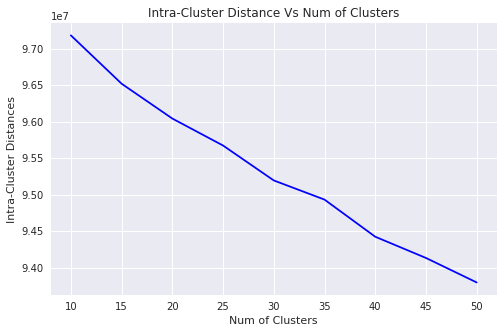

In [270]:
find_best_k(fitted_models)

In [271]:
cluster17 = fitted_models[5]

In [277]:
sorted_data[:100000]['Text'][cluster17.labels_ == 34]

3213      I have relied on these cake mixes for a few ye...
3060      Panko bread crumbs are just awesome.  When use...
4419      1. You can make low carb pancakes with wheat g...
12386     There is no gluten free bread out there like t...
5263      I'm just a droolin' fool thinkin' about these ...
20061     You cannot beat Dutch Gold. They are economica...
30988     If you're looking for an easy-to-use pancake m...
5108      The waffle cone mix came with three pounds of ...
19596     Buy these cookies. You will not regret it.<br ...
19472     My wife and I started a tradition years ago wh...
39636     After recently finding out my daughter has foo...
40205     This is one of the best gluten-free brownies t...
19474     For years we have used Boboli pizza crust and ...
40194     I have been off gluten for three months and al...
39512     I bought these for my girlfriend who can not e...
39693     My wife and son have gluten allergies and most...
39516     My son and I have been eating 

In [ ]:
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

In [236]:
#Finding TF-IDF vector representation 
tf_idf_vect = TfidfVectorizer(min_df = 0)

In [237]:
fitted_models_tfidf = kmean_cluster(sorted_data.iloc[:100000], tf_idf_vect, 'TFIDF')

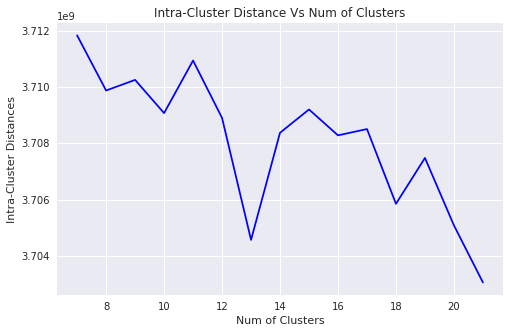

In [238]:
find_best_k(fitted_models_tfidf)

In [239]:
cluster13 = fitted_models_tfidf[6]

In [245]:
sorted_data[:100000]['Text'][cluster13.labels_ == 1]

61921    Like most people, I have been a fan of chocola...
Name: Text, dtype: object

In [8]:
#Importing Libraries 
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [9]:
#Cleaning html tags
def cleanhtml(sentence): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

#Cleaning special symbols from texts
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [10]:
#cleaning each text
import re
i = 0
list_of_sent = []
for sent in sorted_data['Text'].values:
    filtered_sentence = []
    sent = cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [11]:
#Determining average Word2Vec for each review
def avg_w2v(data, model):
    sent_vectors = []
    for sent in data: 
        sent_vec = np.zeros(100) 
        cnt_words =0; 
        for word in sent: # for each word in a review/sentence
            try:
                vec = model.wv[word]
                sent_vec += vec
                cnt_words += 1
            except:
                pass
        sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return np.matrix(sent_vectors)

In [12]:
w2v_model = gensim.models.Word2Vec(list_of_sent[:100000], min_count=5, size=100, workers=8)
w2v_vect = avg_w2v(list_of_sent[:100000], w2v_model)

In [13]:
dbscan = DBSCAN(min_samples=50, p = 2, n_jobs=-1)

In [ ]:
dbscan.fit(w2v_vect)